# InfoGAN - based on OpenAI official code

## Background: GAN

$$
\min_G \max_D V(D,G) = \mathbb{E}_{x\sim P_\text{data}}[\log D(x)] + \mathbb{E}_{z\sim \text{noise}} [\log(1-D(G(z)))]
$$

## InfoGAN

### Main Idea: Mutual Information

$$
\min_G \max_D V_I(D,G) = V(D,G) - \lambda I(c; G(z,c))
$$

### Variational Mutual Information Maximization

One mathmatics:
Mutual information term $I(c; G(z,c))$ is hard to maximize directly as it requires access to the posterior $P(c|x)$. So, we approximate posterior $P(c|x)$ to auxilliary distribution $Q(c|x)$ using variational lower bounds techniques.

## References

* https://github.com/wiseodd/generative-models/blob/master/GAN/infogan/infogan_tensorflow.py
* https://gist.github.com/awjuliani/c9ecd8b37d33d6855cd4ed9aa16ce89f
* https://github.com/openai/InfoGAN (Official codes but hard to understand)

## Network architecture for MNIST

![network_architecutre](infogan_network_architecture.png)

# ToDo

* How about learning rate decay?
    * 그 전에 이 상태에서 학습 스텝을 늘리면 어떻게 되는지부터 봐야 함
    * https://www.facebook.com/groups/TensorFlowKR/permalink/487267351614328/ 참고
        * G가 optimal 하지 않는 한 optimal D가 존재
        * D가 optimal 해지면 G의 gradient 크기가 커지고 variance 가 증가하여 학습이 불안정해짐
        * learning rate decay 혹은 직접적인 gradient scaling 으로 잡을 수 있을 듯
* Thinkabout: gradient scaling
    * gradient 가 loss function 에 대해 어떻게 결정되는지를 생각해보자.
    * 그냥 해보면 될거 같은데 지금은 하기시름
    * loss 가 scalar 로 나오는데 이게 어떻게 각 엘리먼트에 대해 정해지는지 궁금함
    * loss 의 스칼라값이 중요한가? 그러면 +10 해주면 뭐가 바뀜? 그럴거같진 않은데?
    * 암튼 생각해보자.
* code refactoring
    * cross-ent 같은거 직관적이지 않은듯함
    * 보다 log likelihood 기반으로 바꿔주자

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
slim = tf.contrib.slim

In [3]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def lrelu(x, leak=0.1, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [5]:
def dense(inputs, units, activ_fn=tf.nn.relu, use_bn=False, name="dense"):
    with tf.variable_scope(name):
        net = tf.layers.dense(inputs, units, activation=None)
        if use_bn:
            net = tf.layers.batch_normalization(net, training=training)
        if activ_fn:
            net = activ_fn(net)
        
        return net

In [6]:
def conv(inputs, n_filters, kernel_size, strides=1, activ_fn=tf.nn.relu, use_bn=False, name="conv"):
    with tf.variable_scope(name):
        net = tf.layers.conv2d(inputs, n_filters, kernel_size, strides, padding='same')
        if use_bn:
            net = tf.layers.batch_normalization(net, training=training)
        if activ_fn:
            net = activ_fn(net)
        
        return net

In [7]:
def upconv(inputs, n_filters, kernel_size, strides=2, activ_fn=tf.nn.relu, use_bn=False, name="upconv"):
    with tf.variable_scope(name):
        net = tf.layers.conv2d_transpose(inputs, n_filters, kernel_size, strides=strides, padding='same')
        if use_bn:
            net = tf.layers.batch_normalization(net, training=training)
        if activ_fn:
            net = activ_fn(net)
        
        return net

In [8]:
# c1: categorical ~ Cat(10)
# c2, c3: continuous ~ Uniform(-1, 1)
def generator(z, c, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        z_c = tf.concat([z, c], axis=1)
        net = dense(z_c, 1024, use_bn=True, name="dense1")
        net = dense(net, 7*7*128, use_bn=True, name="dense2") # 6272
        net = tf.reshape(net, [-1, 7, 7, 128], name="reshape") # 7x7x128
        net = upconv(net, 64, [4,4], use_bn=True, name="upconv1") # 14x14x64
        net = upconv(net, 1, [4,4], activ_fn=tf.nn.sigmoid, name="upconv2") # 28x28x1
        
        return net

In [9]:
def discriminator_with_Q(x, reuse=False):
    with tf.variable_scope("discriminator_with_Q", reuse=reuse):
        net = tf.reshape(x, [-1, 28, 28, 1])
        net = conv(net, 64, [4,4], strides=2, activ_fn=lrelu, name="conv1") # 14x14x64
        net = conv(net, 128, [4,4], strides=2, activ_fn=lrelu, use_bn=True, name="conv2") # 7x7x128
        net = slim.flatten(net)
        net = dense(net, 1024, activ_fn=lrelu, use_bn=True, name="dense1")
        d_prob = dense(net, 1, activ_fn=tf.nn.sigmoid, name="D_output")
        # Q (encoder)
        net = dense(net, 128, activ_fn=lrelu, use_bn=True, name="Q_dense")
        c_logits = dense(net, 12, activ_fn=None, name="Q_c_logits")
    
        return d_prob, c_logits

In [17]:
# build nets
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
training = tf.placeholder(tf.bool)
z = tf.placeholder(tf.float32, [None, 62])
c = tf.placeholder(tf.float32, [None, 12])
c1, c2, c3 = tf.split(c, [10, 1, 1], axis=1)

G_sample = generator(z, c)
D_real, c_real_logits = discriminator_with_Q(X)
D_fake, c_fake_logits = discriminator_with_Q(G_sample, reuse=True)
Q_c1, Q_c2, Q_c3 = tf.split(c_fake_logits, [10, 1, 1], axis=1)
Q_c1 = tf.nn.softmax(Q_c1)


D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8)) # heuristic non-saturation loss

# categorical loss
Q_c1_log_q_c_given_x = tf.reduce_sum(tf.log(Q_c1 + 1e-8) * c1, axis=1) # log likelihood
Q_c1_log_q_c = tf.reduce_sum(tf.log(0.1) * c1, axis=1) # log likelihood of c1~Cat(10, 0.1)
Q_c1_xent = tf.reduce_mean(-Q_c1_log_q_c_given_x) # cross-entropy
Q_c1_ent = tf.reduce_mean(-Q_c1_log_q_c) # entropy
Q_c1_mi = Q_c1_xent + Q_c1_ent

# continuous loss - 사실 c2, c3 은 각각 1개라 reduce_sum 안해도 됨
# Q_c2_loss = tf.reduce_sum(0.5 * (Q_c2 - c2)**2, axis=1)
# Q_c3_loss = tf.reduce_sum(0.5 * (Q_c3 - c3)**2, axis=1)
# Q_loss = tf.reduce_mean(Q_c1_loss + Q_c2_loss + Q_c3_loss)
# gaussian. 논문에는 uniform 으로 나와있는데 흠...

# 아래 값들이 왜 xent / ent 가 되는가?
# 적분식을 생각하지말고 익스펙테이션 식을 생각해라!
# 미니배치가 샘플링한거고 reduce_mean 을 하면 익스펙테이션이 된다.

# loglike[Q(c2|x)]
Q_c2_log_q_c_given_x = tf.reduce_sum(-0.5*np.log(2*np.pi) - tf.log(1.0) - 0.5*tf.square(c2 - Q_c2), axis=1) 
# loglike[P(c)]
Q_c2_log_q_c = tf.reduce_sum(-0.5*np.log(2*np.pi) - tf.log(1.0) - 0.5*tf.square(c2 - 0.0), axis=1)
# H(Q, c)
Q_c2_xent = tf.reduce_mean(-Q_c2_log_q_c_given_x)
# H(c)
Q_c2_ent = tf.reduce_mean(-Q_c2_log_q_c) # H(c)
Q_c2_mi = -Q_c2_xent + Q_c2_ent

Q_c3_log_q_c_given_x = tf.reduce_sum(-0.5*np.log(2*np.pi) - tf.log(1.0) - 0.5*tf.square(c3 - Q_c3), axis=1)
Q_c3_log_q_c = tf.reduce_sum(-0.5*np.log(2*np.pi) - tf.log(1.0) - 0.5*tf.square(c3 - 0.0), axis=1)
Q_c3_xent = tf.reduce_mean(-Q_c3_log_q_c_given_x)
Q_c3_ent = tf.reduce_mean(-Q_c3_log_q_c)
Q_c3_mi = -Q_c3_xent + Q_c3_ent

ld = 1.0 # lambda
mutual_information = Q_c1_mi + Q_c2_mi + Q_c3_mi
D_loss -= mutual_information * ld
G_loss -= mutual_information * ld

var_D_Q = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="discriminator_with_Q")
var_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator")

# lambda = 1
# D_train_op = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(D_loss, var_list=var_D_Q)
# G_train_op = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5).minimize(G_loss, var_list=var_G)

# batchnorm control dependencies
G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator_with_Q')
with tf.control_dependencies(G_update_ops):
    G_train_op = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5).minimize(G_loss, var_list=var_G)
with tf.control_dependencies(D_update_ops):
    D_train_op = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(D_loss, var_list=var_D_Q)

[<tf.Tensor 'gradients/split_1_grad/concat:0' shape=(?, 12) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/split_1_grad/concat:0' shape=(?, 12) dtype=float32>, None, None]


In [11]:
# 62 / 10 / 2

def sample_z(n):
#     return np.random.randn(n, 62) # standard normal dist
    return np.random.uniform(-1, 1, [n, 62]) # uniform

def sample_c1(n):
    return np.random.multinomial(1, [0.1]*10, size=n)

def sample_c_cont(n):
    return np.random.uniform(-1, 1, [n, 1])

def sample_c(n):
    return np.concatenate([sample_c1(n), sample_c_cont(n), sample_c_cont(n)], axis=1)

In [12]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [13]:
def plot_c1():
    z_ = sample_z(16)
    # c1 을 이렇게 줘야 같은 c1 다른 noise z_ 에 대해서 동일한 샘플을 생성하는지 알 수 있음
    idx = np.random.randint(0, 10)
    c1_ = np.zeros([16, 10])
    c1_[range(16), idx] = 1
    c2_ = sample_c_cont(16)
    c3_ = sample_c_cont(16)
    c_ = np.concatenate([c1_, c2_, c3_], axis=1)
    samples = sess.run(G_sample, {z: z_, c: c_, training: False})
    fig = plot(samples)
    plt.show()

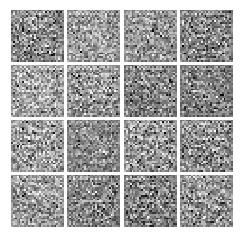

[1/50000] D_loss: -2.5060 | G_loss: -5.5693


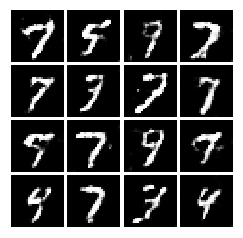

[1001/50000] D_loss: -19.8162 | G_loss: -20.0268


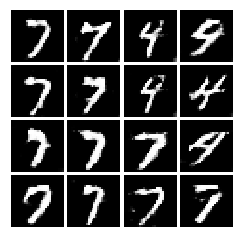

[2001/50000] D_loss: -19.7407 | G_loss: -20.1529


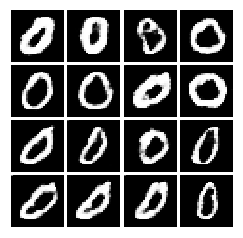

[3001/50000] D_loss: -19.6736 | G_loss: -20.1790


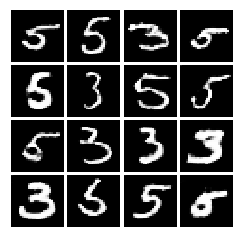

[4001/50000] D_loss: -19.8185 | G_loss: -20.1254


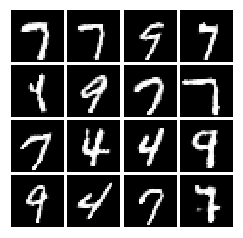

[5001/50000] D_loss: -19.8714 | G_loss: -20.1075


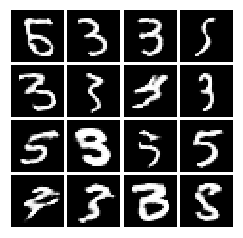

[6001/50000] D_loss: -19.9420 | G_loss: -19.7179


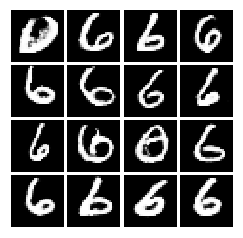

[7001/50000] D_loss: -20.0463 | G_loss: -19.7981


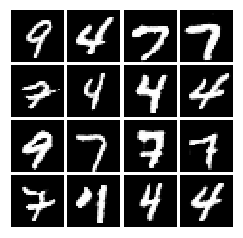

[8001/50000] D_loss: -20.1246 | G_loss: -19.4348


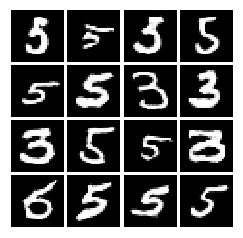

[9001/50000] D_loss: -20.2103 | G_loss: -19.4511


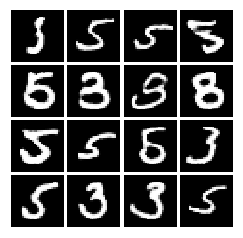

[10001/50000] D_loss: -20.2396 | G_loss: -19.6658


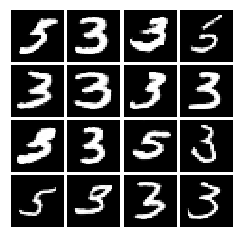

[11001/50000] D_loss: -20.3675 | G_loss: -19.1347


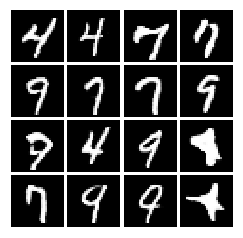

[12001/50000] D_loss: -20.3115 | G_loss: -19.2832


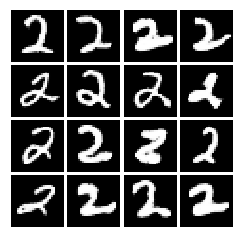

[13001/50000] D_loss: -20.2823 | G_loss: -19.8058


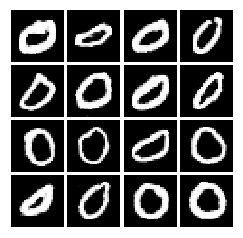

[14001/50000] D_loss: -20.3863 | G_loss: -19.4838


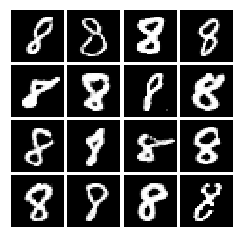

[15001/50000] D_loss: -20.4334 | G_loss: -18.6200


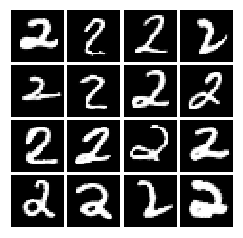

[16001/50000] D_loss: -20.4132 | G_loss: -18.6790


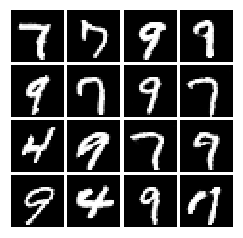

[17001/50000] D_loss: -20.4064 | G_loss: -19.0255


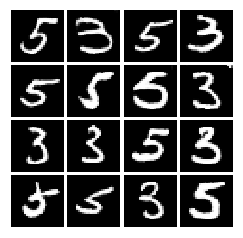

[18001/50000] D_loss: -20.5519 | G_loss: -18.7664


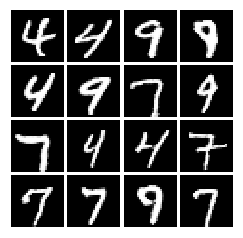

[19001/50000] D_loss: -20.6352 | G_loss: -18.5201


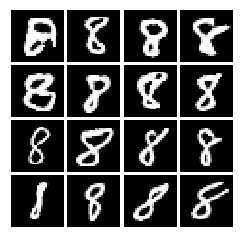

[20001/50000] D_loss: -20.5653 | G_loss: -18.3184


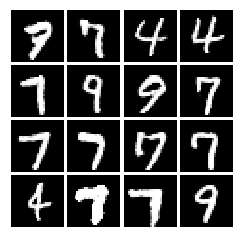

[21001/50000] D_loss: -20.6304 | G_loss: -18.2671


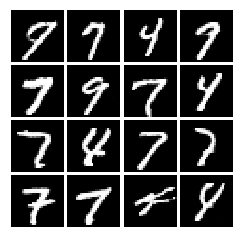

[22001/50000] D_loss: -20.5320 | G_loss: -18.6108


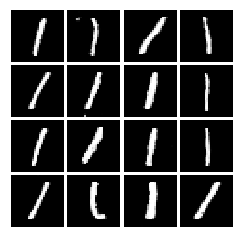

[23001/50000] D_loss: -20.6268 | G_loss: -18.3568


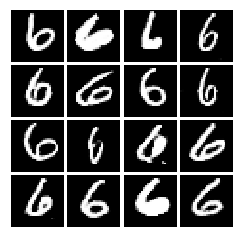

[24001/50000] D_loss: -20.6256 | G_loss: -17.9982


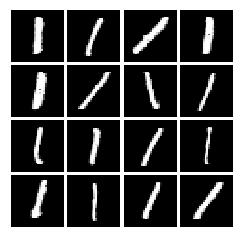

[25001/50000] D_loss: -20.5913 | G_loss: -18.0346


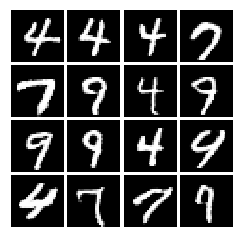

[26001/50000] D_loss: -20.6646 | G_loss: -17.7135


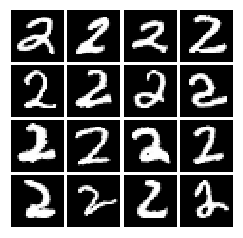

[27001/50000] D_loss: -20.7230 | G_loss: -17.9365


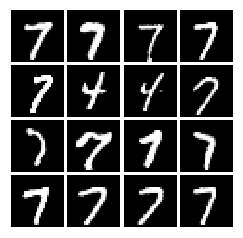

[28001/50000] D_loss: -20.6262 | G_loss: -17.8821


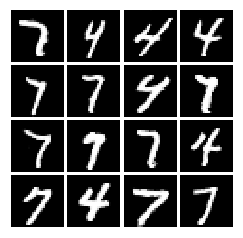

[29001/50000] D_loss: -20.6854 | G_loss: -18.5348


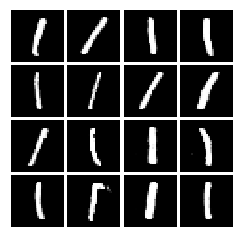

[30001/50000] D_loss: -20.7031 | G_loss: -17.6977


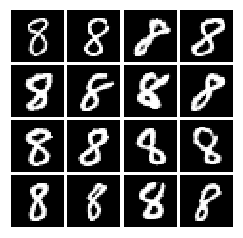

[31001/50000] D_loss: -20.6206 | G_loss: -17.8925


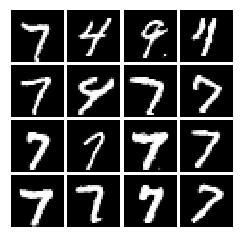

[32001/50000] D_loss: -20.6630 | G_loss: -18.3488


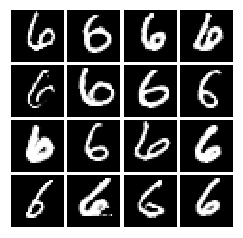

[33001/50000] D_loss: -20.7202 | G_loss: -17.5286


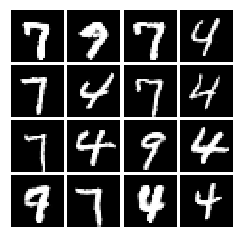

[34001/50000] D_loss: -20.7769 | G_loss: -17.3421


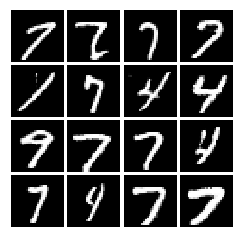

[35001/50000] D_loss: -20.7031 | G_loss: -17.2910


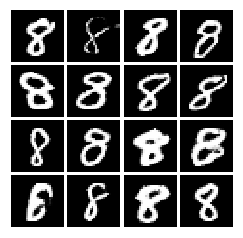

[36001/50000] D_loss: -20.7983 | G_loss: -17.0050


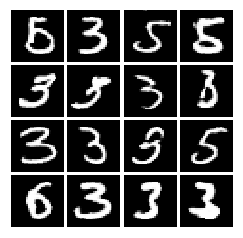

[37001/50000] D_loss: -20.7789 | G_loss: -17.5487


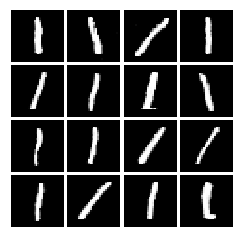

[38001/50000] D_loss: -20.7340 | G_loss: -17.2187


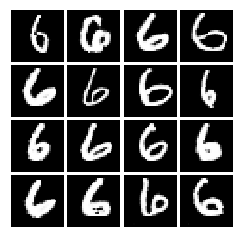

[39001/50000] D_loss: -20.7459 | G_loss: -16.5133


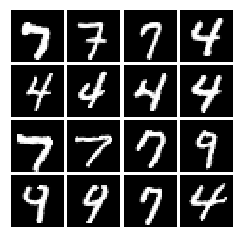

[40001/50000] D_loss: -20.7196 | G_loss: -16.9601


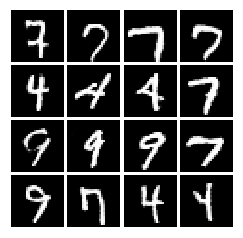

[41001/50000] D_loss: -20.7989 | G_loss: -17.0062


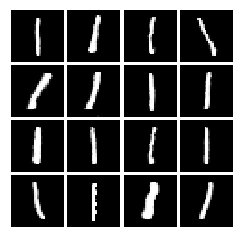

[42001/50000] D_loss: -20.7484 | G_loss: -17.2479


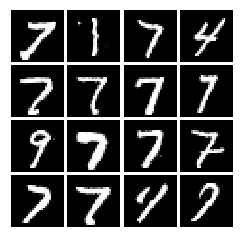

[43001/50000] D_loss: -20.6710 | G_loss: -17.1915


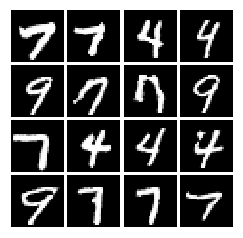

[44001/50000] D_loss: -20.8073 | G_loss: -16.5640


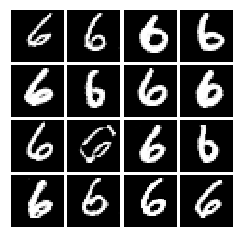

[45001/50000] D_loss: -20.7187 | G_loss: -16.5858


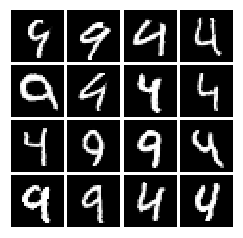

[46001/50000] D_loss: -20.8889 | G_loss: -16.5596


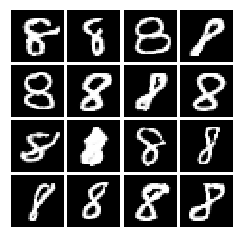

[47001/50000] D_loss: -20.7430 | G_loss: -17.1361


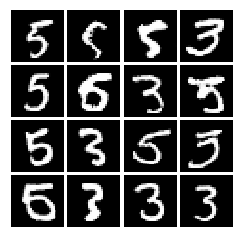

[48001/50000] D_loss: -20.7101 | G_loss: -16.5307


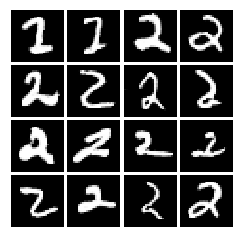

[49001/50000] D_loss: -20.7458 | G_loss: -16.7772


In [18]:
batch_size = 128
n_iter = 50000
print_step = 1000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(n_iter):
    if i % print_step == 0:
        plot_c1()
        plt.show()
    
    batch_x, _ = mnist.train.next_batch(batch_size)
    z_ = sample_z(batch_size)
    c_ = sample_c(batch_size)
    
    _, D_loss_cur = sess.run([D_train_op, D_loss], {X: batch_x, z: z_, c: c_, training: True})
    _, G_loss_cur = sess.run([G_train_op, G_loss], {z: z_, c: c_, training: True})
#     _, Q_loss_cur = sess.run([Q_train_op, Q_loss], {z: z_, c1: c1_, c2: c2_, c3: c3_, training: True})
    
    if i % print_step == 0:
        print('[{}/{}] D_loss: {:.4f} | G_loss: {:.4f}'.
              format(i+1, n_iter, D_loss_cur, G_loss_cur))
        

# Results analysis

In [39]:
def plot_10(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [76]:
def plot_c23(c2_=np.zeros([100, 1]), c3_=np.zeros([100, 1])):
    n = 100
    z_ = sample_z(n)
    c1_ = np.zeros([n, 10])
    idx = np.arange(n) / int(n**0.5)
    c1_[range(n), idx] = 1
#     c2_ = sample_c_cont(16)
#     c3_ = sample_c_cont(16)
#     c2_ = np.tile(np.arange(-1.8, 2, 0.4), 10).reshape(-1, 1)
#     c3_ = np.zeros([n, 1])
    c_ = np.concatenate([c1_, c2_, c3_], axis=1)
    samples = sess.run(G_sample, {z: z_, c: c_, training: False})
    fig = plot_10(samples)
    plt.show()

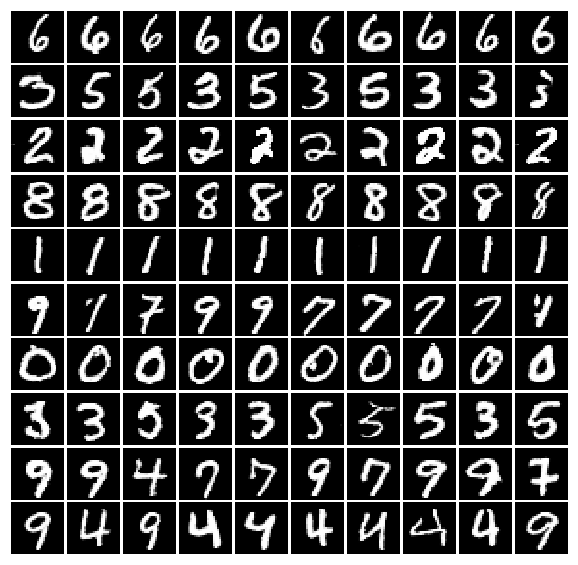

In [77]:
plot_c23()

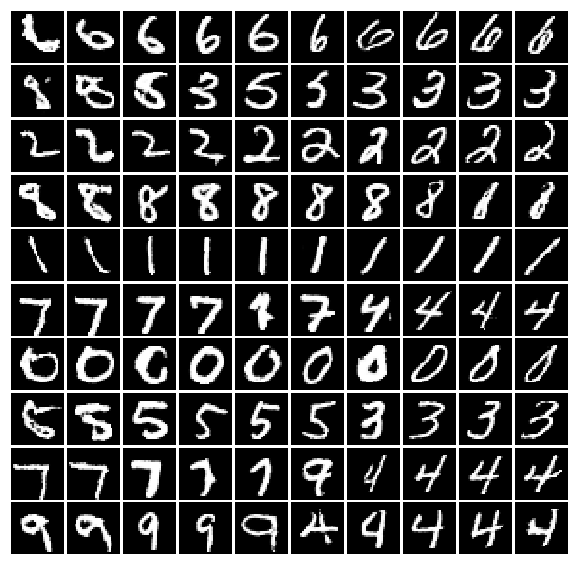

In [93]:
plot_c23(c2_=np.tile(np.linspace(-2, 2, 10), 10).reshape(-1, 1))

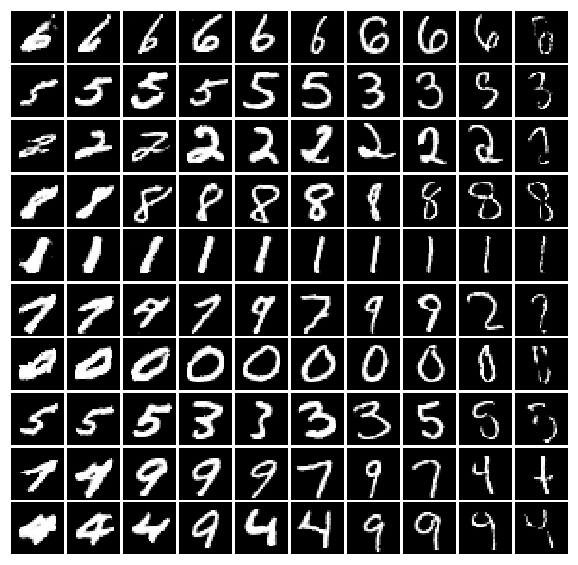

In [92]:
plot_c23(c3_=np.tile(np.linspace(-2, 2, 10), 10).reshape(-1, 1))